In [1]:
#import libraries
import pandas as pd;
import geopandas as gpd;
import matplotlib.pyplot as plt;
import numpy as np; #Using numpy for regex
import pgeocode; #Used to convert postcodes to locations
from shapely.geometry import Point # Shapely for converting latitude/longtitude to geometry

In [2]:
#Load FL Data
df = pd.read_excel(r'volumes.xlsx', sheet_name='Raw Exports', header=0)
df['PC_Area'] = df['CDPostCode'].str.extract(r'(^[a-zA-Z][a-zA-Z]?)')
df['PC_District'] = df['CDPostCode'].str.extract(r'([^\s]+)')

In [3]:
#Set up Freightliner locations
data = [['Leeds', 53.7496, -1.5494], ['Doncaster', 53.497, -1.1821]]
  
# Create the pandas DataFrame
fl_locations = pd.DataFrame(data, columns=['Terminal', 'Lat', 'Long'])  

# print dataframe.
fl_locations

# creating a geometry column 
geometry = [Point(xy) for xy in zip(fl_locations['Long'], fl_locations['Lat'])]
# Coordinate reference system : WGS84
#crs = {'init': 'epsg:4326'}
crs = 'epsg:4326'
# Creating a Geographic data frame 
fl_points = gpd.GeoDataFrame(fl_locations, crs=crs, geometry=geometry)

indexed_fl_points = fl_points.set_index('Terminal')
indexed_fl_points

,Lat,Long,geometry
Terminal,,,
Leeds,53.7496,-1.5494,POINT (-1.54940 53.74960)
Doncaster,53.4970,-1.1821,POINT (-1.18210 53.49700)


In [4]:
explore = df.groupby(["JobType", "Load"])["Unload"].count().reset_index()
explore

,JobType,Load,Unload
0,Export,CANNOCK,2
1,Export,DONCASTER,70
2,Export,HULL,4
3,Export,IMMINGHAM,224
4,Export,KEGWORTH,1
5,Export,LEEDS,1845
6,Export,LIFT ON CONTAINER,3
7,Export,LIVERPOOL,1
8,Export,NORMANTON,1
9,Export,PARIS RELOAD,7


In [8]:
#Inclusion & Exclusion Criteria
#TODO: Separate maps for Leeds and Doncaster

load_included = ['LEEDS']
Postcode_excluded = ['TESC']
slice = df[(df.Load.str.contains('|'.join(load_included))) & ~(df.CDPostCode.str.contains('|'.join(Postcode_excluded)))]
slice

,JobType,Load,ColDel,CDPostCode,letterLetter,Unload,PC_Area,PC_District
15,Export,LEEDS,BRADFORD,BD4 7TT,BD4,WAKEFIELD,BD,BD4
16,Export,LEEDS,BRADFORD,BD4 7TT,BD4,WAKEFIELD,BD,BD4
17,Export,LEEDS,BRADFORD,BD4 7TT,BD4,WAKEFIELD,BD,BD4
18,Export,LEEDS,BRADFORD BD4 7TT,BD4 7TT,BD4,WAKEFIELD,BD,BD4
19,Export,LEEDS,BRADFORD BD4 7TT,BD4 7TT,BD4,WAKEFIELD,BD,BD4
...,...,...,...,...,...,...,...,...
2525,Export,LEEDS,GAINSBOROUGH,DN21 3LF,DN21,DONCASTER,DN,DN21
2526,Export,LEEDS,GAINSBOROUGH,DN21 3LF,DN21,DONCASTER,DN,DN21
2527,Export,LEEDS,GAINSBOROUGH,DN21 3LF,DN21,DONCASTER,DN,DN21
2529,Export,LEEDS,SHERBURN IN ELMET,LS25 6JH,LS25,DONCASTER,LS,LS25


# Postcode District Level Analysis (e.g., LN10)

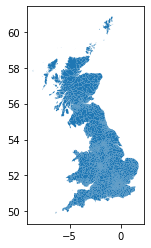

In [9]:
#Load and check map of PostCode Districts
fp = "postcodes/Districts.shp"
map_df = gpd.read_file(fp)
map_df.plot()

In [10]:
#Examine Header data of map
map_df.head()

,name,geometry
0,AB10,"POLYGON ((-2.11645 57.14656, -2.11655 57.14663..."
1,AB11,"MULTIPOLYGON (((-2.05257 57.13426, -2.05729 57..."
2,AB12,"MULTIPOLYGON (((-2.12807 57.03684, -2.12986 57..."
3,AB13,"POLYGON ((-2.26153 57.10694, -2.27015 57.11525..."
4,AB14,"POLYGON ((-2.26153 57.10694, -2.26315 57.10619..."


In [11]:
#Aggregate postcodes with total containers for the year
aggregate_district = slice.groupby(["PC_District"])['Unload'].count().reset_index()
sorted_area = aggregate_district.sort_values(by = "Unload", ascending = 0).head(20)
#sorted_area['Unit_pct'] = sorted_area.Unload / df.Unload.sum()
#sorted_area.style.format({
#    'Unit_pct': '{:,.1%}'.format,
#})
sorted_area


,PC_District,Unload
24,DL1,408
16,BD4,89
94,LS25,82
45,DN40,70
75,HX5,70
15,BD3,53
146,S80,44
153,TS2,40
182,YO42,33
57,HG4,33


In [12]:
reset_index = map_df.set_index("name")
merged = reset_index.join(aggregate_district.set_index("PC_District"))
merged["Unload"] = merged["Unload"].fillna(0)
merged

,geometry,Unload
name,,
AB10,"POLYGON ((-2.11645 57.14656, -2.11655 57.14663...",0.0
AB11,"MULTIPOLYGON (((-2.05257 57.13426, -2.05729 57...",0.0
AB12,"MULTIPOLYGON (((-2.12807 57.03684, -2.12986 57...",0.0
AB13,"POLYGON ((-2.26153 57.10694, -2.27015 57.11525...",0.0
AB14,"POLYGON ((-2.26153 57.10694, -2.26315 57.10619...",0.0
...,...,...
YO90,"MULTIPOLYGON (((-1.08958 53.95931, -1.08891 53...",0.0
YO91,"POLYGON ((-1.06530 53.97796, -1.06634 53.97830...",0.0
ZE1,"MULTIPOLYGON (((-1.17282 60.12108, -1.18797 60...",0.0


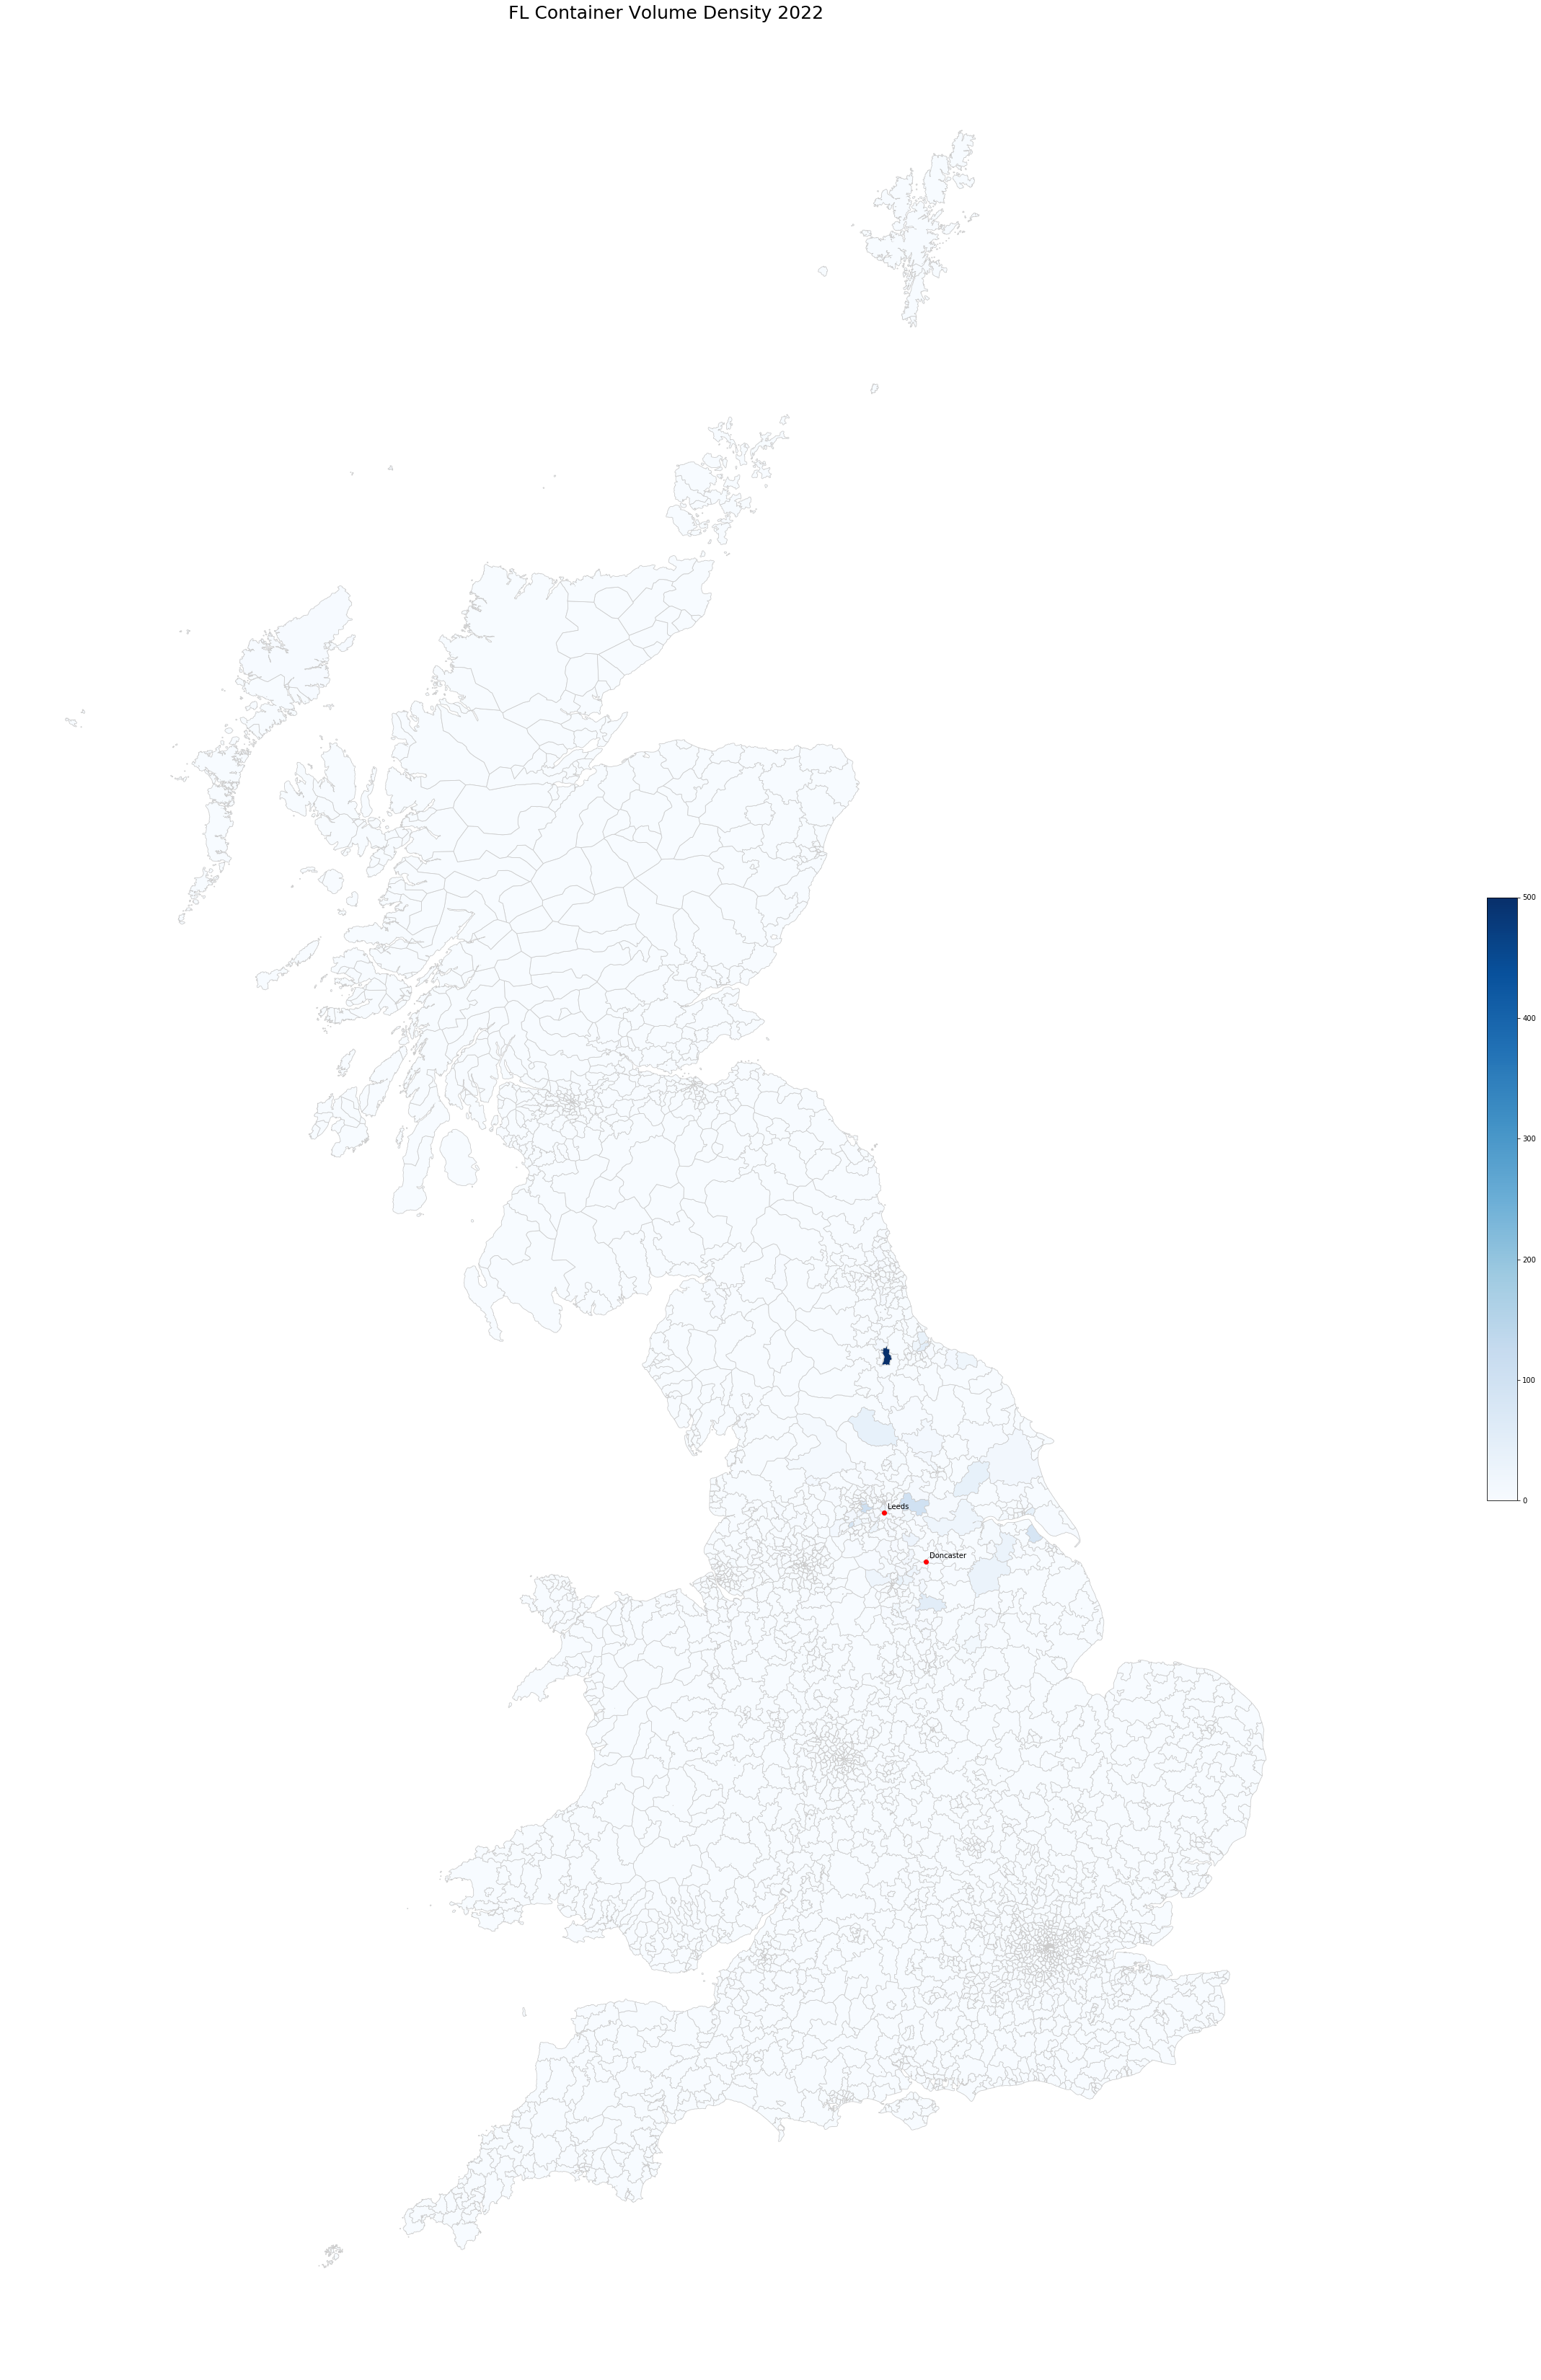

In [13]:
variable = "Unload"
vmin, vmax = 0, 500
fig, ax = plt.subplots(1, figsize=(100, 60))

# add a title and remove axis
ax.set_title("FL Container Volume Density 2022", fontdict={'fontsize': '25', 'fontweight' : '3'})
ax.axis('off')

# Create colorbar as a legend
sm = plt.cm.ScalarMappable(cmap="Blues", norm=plt.Normalize(vmin=vmin, vmax=vmax))
# empty array for the data range
sm._A = []
# add the colorbar to the figure
cbar = fig.colorbar(sm, fraction=0.0075, pad=0.04)


ax.annotate("Leeds", (indexed_fl_points.loc["Leeds"]["Long"], indexed_fl_points.loc["Leeds"]["Lat"]), xycoords='data', xytext=(5,5), textcoords="offset points")
ax.annotate("Doncaster", (indexed_fl_points.loc["Doncaster"]["Long"], indexed_fl_points.loc["Doncaster"]["Lat"]), xycoords='data', xytext=(5,5), textcoords="offset points")


merged.plot(column=variable, cmap='Blues', linewidth=0.8, ax=ax, edgecolor='0.8')
fl_points.plot(ax=ax, color="red")



# Postcode Area-level analysis (e.g., LN)

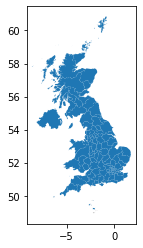

In [14]:
#Load and check map of PostCode Districts
fp_areas = "postcodes/Areas.shp"
map_df_areas = gpd.read_file(fp_areas)
map_df_areas.plot()

In [15]:
# Create Column with Postcode Area (one or two letters)
area_df = slice

In [16]:
#Aggregate postcodes with total containers for the year
aggregate_area = area_df.groupby(["PC_Area"])["Unload"].count().reset_index()
aggregate_area

,PC_Area,Unload
0,BB,15
1,BD,196
2,CA,4
3,DH,7
4,DL,420
5,DN,180
6,HD,26
7,HG,40
8,HS,2
9,HU,65


In [17]:
reset_index = map_df_areas.set_index("name")
merged_area = reset_index.join(aggregate_area.set_index("PC_Area"))
merged_area["Unload"] = merged_area["Unload"].fillna(0)
merged_area

,geometry,Unload
name,,
AB,"POLYGON ((-2.21091 56.88580, -2.21858 56.88676...",0.0
AL,"POLYGON ((-0.37138 51.68730, -0.37227 51.68781...",0.0
B,"POLYGON ((-2.05436 52.24756, -2.05530 52.25006...",0.0
BA,"POLYGON ((-2.08430 51.31717, -2.08008 51.31421...",0.0
BB,"POLYGON ((-2.21557 53.73160, -2.21541 53.73145...",15.0
...,...,...
ZE,"MULTIPOLYGON (((-0.80210 60.40932, -0.80233 60...",0.0
BT,"MULTIPOLYGON (((-5.54258 54.29000, -5.54922 54...",0.0
GY,"MULTIPOLYGON (((-2.36625 49.40170, -2.36750 49...",0.0


In [18]:
nomi = pgeocode.Nominatim('GB')
nomi.query_postal_code("S9 1")

postal_code                                S9
country_code                               GB
place_name        Tinsley, Darnall, Wincobank
state_name                            England
state_code                                ENG
county_name                   South Yorkshire
county_code                           2637273
community_name                            NaN
community_code                            NaN
latitude                              53.4099
longitude                            -1.40847
accuracy                                    4
Name: 0, dtype: object

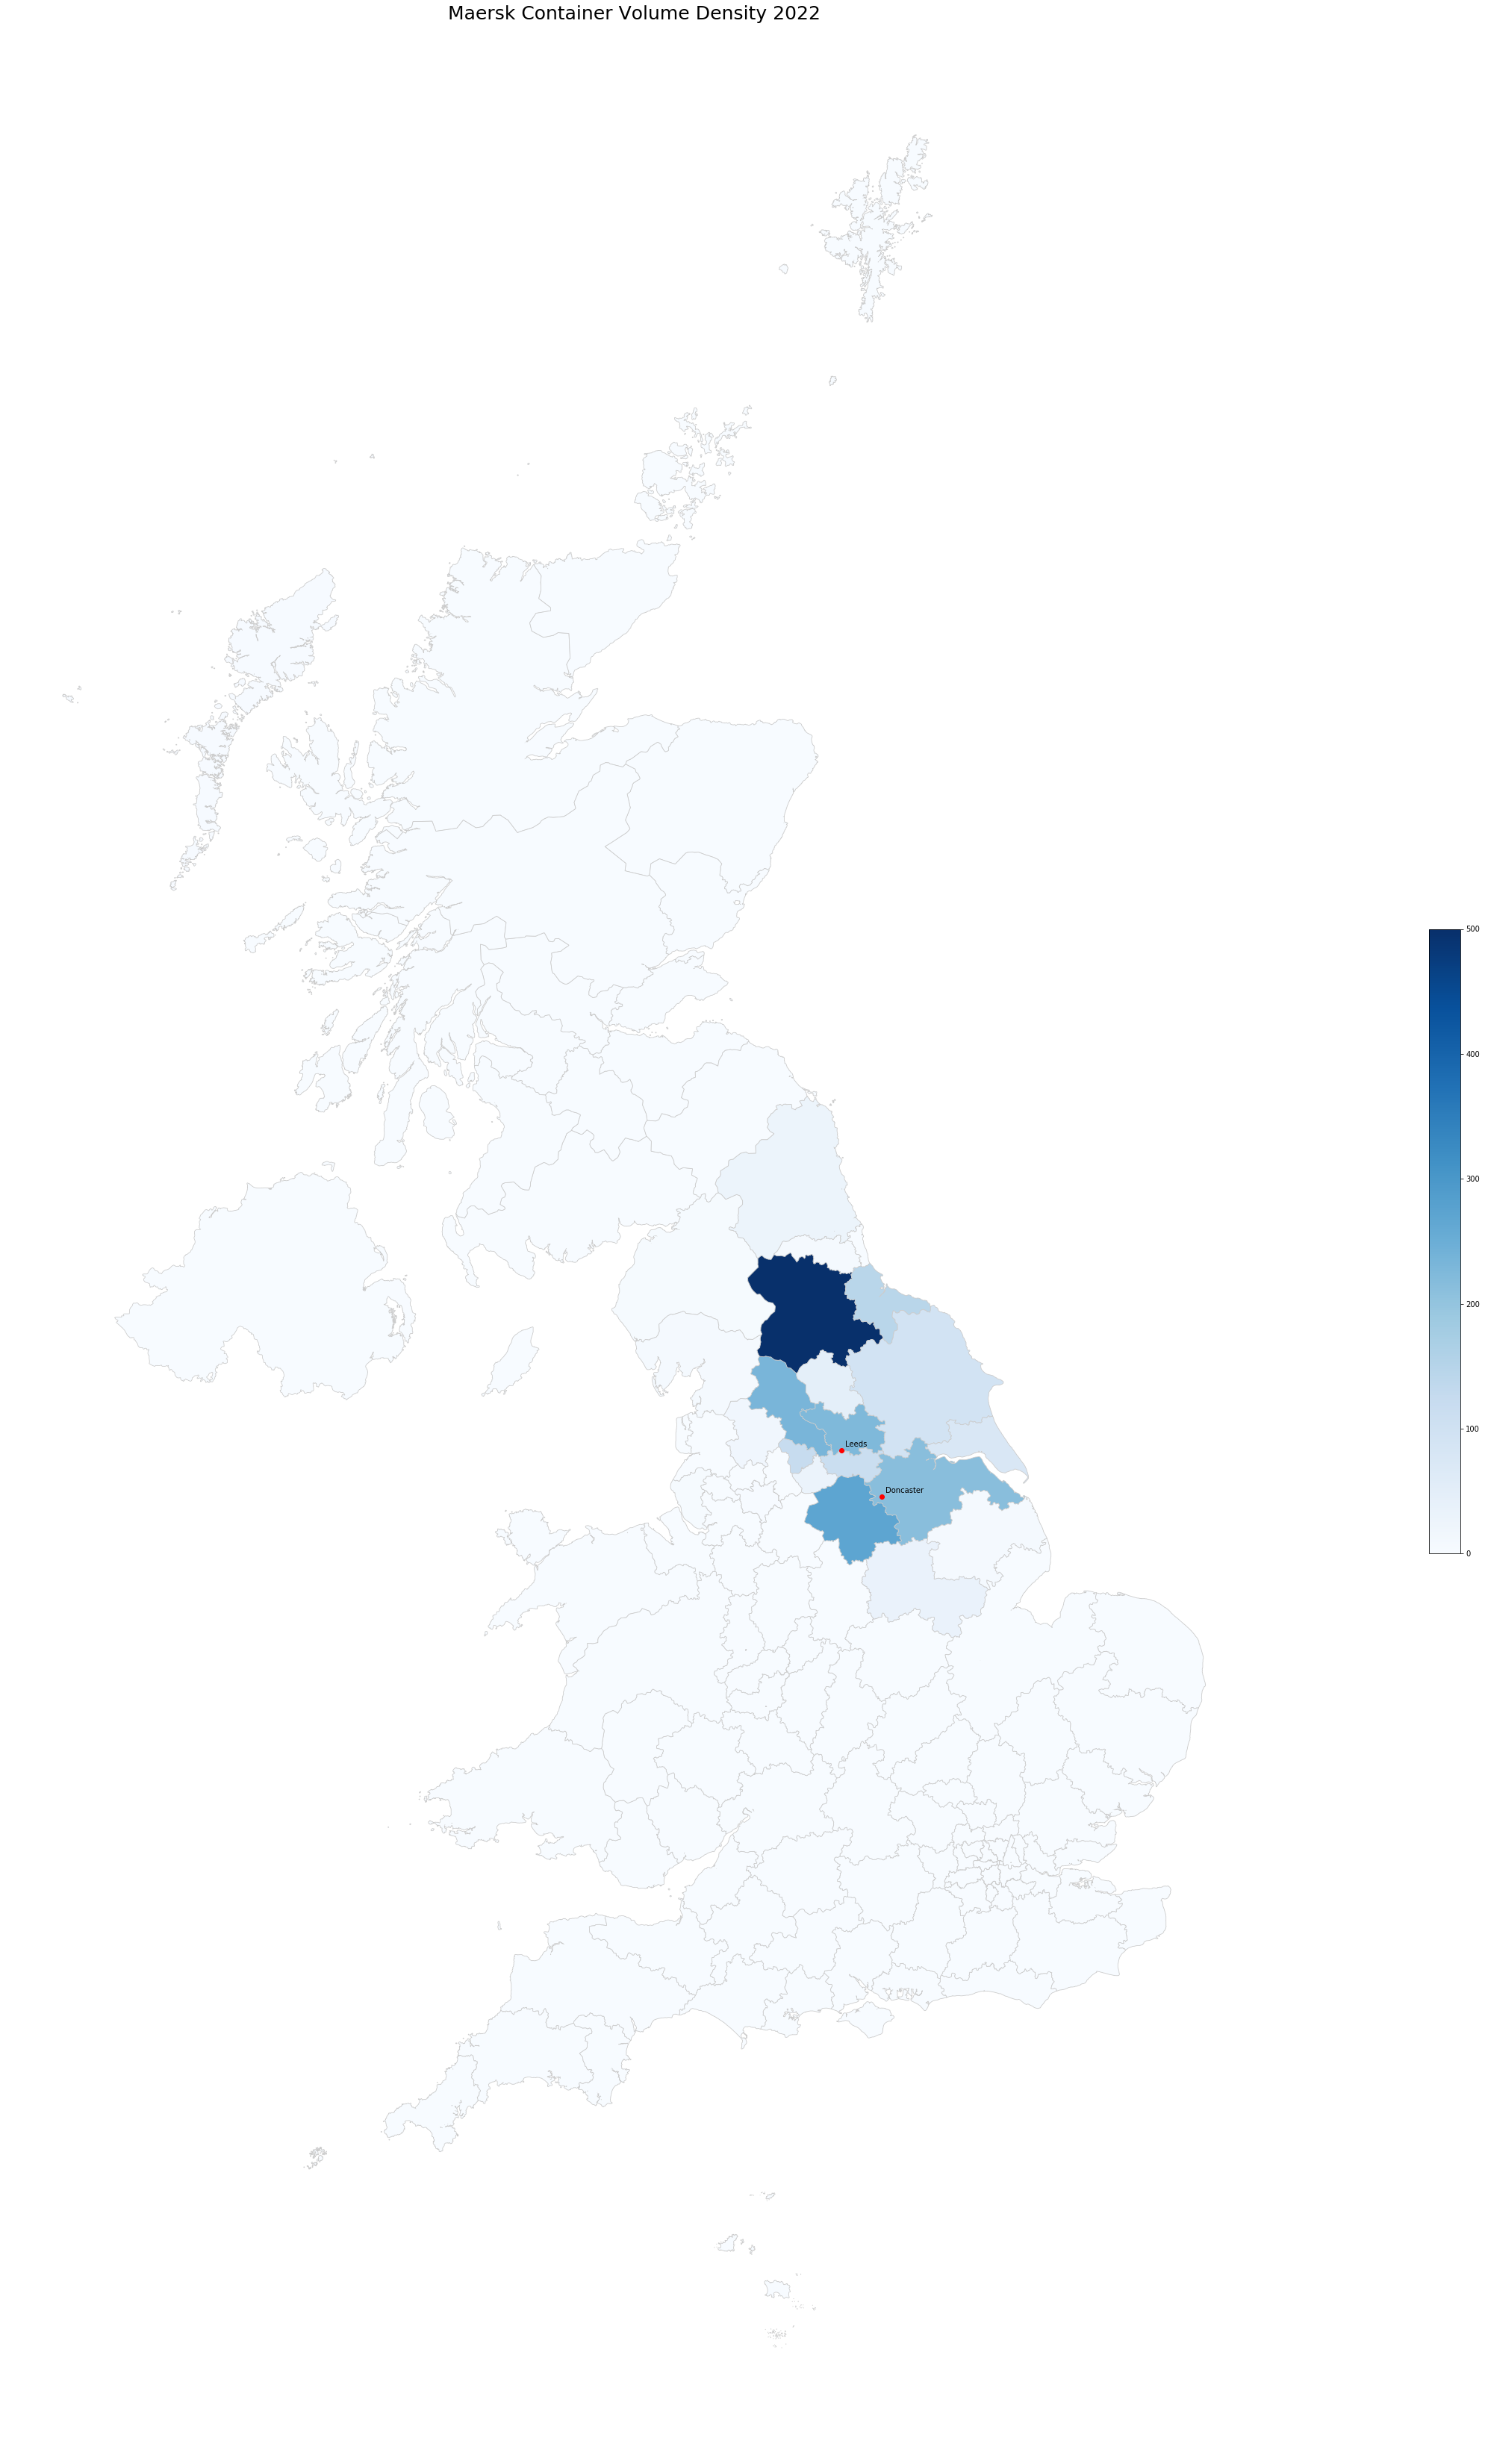

In [19]:
fig_com, ax_com = plt.subplots(1, figsize=(100, 60))
ax_com.axis('off')

vmin_area, vmax_area = 0, 500
# add a title
ax_com.set_title("Maersk Container Volume Density 2022", fontdict={'fontsize': '25', 'fontweight' : '3'})

# Create colorbar as a legend
sm = plt.cm.ScalarMappable(cmap="Blues", norm=plt.Normalize(vmin=vmin_area, vmax=vmax_area))
# empty array for the data range
sm._A = []
# add the colorbar to the figure
cbar = fig_com.colorbar(sm, fraction=0.0075, pad=0.04)

ax_com.annotate("Leeds", (indexed_fl_points.loc["Leeds"]["Long"], indexed_fl_points.loc["Leeds"]["Lat"]), xycoords='data', xytext=(5,5), textcoords="offset points")
ax_com.annotate("Doncaster", (indexed_fl_points.loc["Doncaster"]["Long"], indexed_fl_points.loc["Doncaster"]["Lat"]), xycoords='data', xytext=(5,5), textcoords="offset points")

merged_area.plot(column=variable, cmap='Blues', linewidth=0.8, ax=ax_com, edgecolor='0.8') 
fl_points.plot(ax=ax_com, color="red")